# **Classification of Electron-Proton Scattering Products**.

Comparison of different *supervised learning* models for the *classification* of particles produced during inelastic electron-proton scattering based on the response of six different detectors. The goal is to identify particles and evaluate the best model among the following:

- **Decision Tree**
- **Random Forest**
- **Multilayer Perceptron**
- **K-Nearest Neighbor**

The data used are the product of the response of six different detectors using the simulation platform *[GEANT4](https://geant4.web.cern.ch/)*. The DataSet can be found at *[Kaggle](https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses)*.

## **Exploratory Analysis & Data Preparation**.

Importing the modules and libraries of interest, useful for dataset analysis.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Loading DataSet

In [17]:
df = pd.read_csv("GEANT4_Simulation.csv")
df.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


For better readability I rename the **id** and **nphe** column.

I also replace the *code* associated with each particle with its **name** by remapping the values. For this operation I use the [`dict.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html) method.

In [18]:
# Dictionary containing the key value association id:name

dictParticles = { -11 : 'positron',
                  211 : 'pion',
                  321 : 'kaone',
                  2212 : 'proton'}

**Composizione DataSet**

|    Features    |              Meaning              | Dimension |
| :-------------: | :------------------------------------: | :--------------: |
|  **id**  |            Particle Name            |    $NoDim$    |
|   **p**   |           Momentum           |    $GeV/c$    |
| **theta** |          Scattering angle          |     $rad$     |
| **beta** | Relativistic Velocity $v$ e $c$ |    $NoDim$    |
| **nphe** |        Number of Photoelectrons        |    $NoDim$    |
|  **ein**  |          Input Energy          |     $GeV$     |
| **eout** |           Output Energy           |     $GeV$     |


**Particles Values**

|    id    |              Particle              | Symbol |        Mass (MeV)   |  
| :-------------: | :------------------------------------: | :--------------: | :--------: |
|  **(-11)**  |            Positron            |    $e^+$    | $0.51$ |
|   **(211)**   |           Pion           |    $\pi \quad (\pi^0,\pi^+,\pi^-)$    | $133$ |
| **(321)** |          Kaon          |     $K \quad (K^0,K^+,K^-)$      | $495$ |
| **(2212)** | Proton |     $p$     | $940$ |


In [19]:
# Renaming the 'id' and 'nphe' columns.
df.rename(columns={'id' : 'particle'}, inplace=True)
df.rename(columns={'nphe' : 'electron'}, inplace=True)

# I will remap the values of the column 'particle'
df['particle'] = df['particle'].map(dictParticles)

In [20]:
df.head(10)

,particle,p,theta,beta,electron,ein,eout
0,pion,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,pion,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,proton,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,pion,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,proton,2.123290,0.337332,0.908652,0,0.034379,0.049256
5,pion,0.403296,0.694215,0.958553,0,0.000000,0.000000
6,proton,1.382620,0.436689,0.844835,0,0.200275,0.053651
7,proton,1.133130,0.276831,0.781295,0,0.044038,0.093980
8,proton,0.656291,0.542507,0.560291,0,0.083406,0.000000
9,proton,2.077210,0.130479,0.909951,0,0.036164,0.045960


I now check if any features are missing for some particle and check the dimensionality of the dataframe. To do this I use [`pd.DataFrame.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html) and [`pd.DataFrame.sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html).

In [21]:
print(df.isnull().sum())
print("-"*20)
print(df.shape)

particle    0
p           0
theta       0
beta        0
electron    0
ein         0
eout        0
dtype: int64
--------------------
(5000000, 7)


There are five million particles, each with six features, and no data is missing.

Looking at the dataset I hypothesize that the detector about *electrons* was **inneficient** (it often scores 0). I verify this hypothesis and possibly eliminate the column before training the models.

In [22]:
flop = df['electron'].value_counts(normalize = True)
print('The detector misses the signal the {times:.2%} of times'.format(times=flop[0]))

The detector misses the signal the 93.52% of times


Therefore I can eliminate the feature **electrons**, as it is not significant.

In [23]:
df.drop(columns = ['electron'], inplace=True)

In addition, I can also remove those **physically inconsistent** data due to detector inefficiency or statistical errors by removing all those particles that exceed the threshold value:

**$\beta=\frac{v}{c}\geq1$**

In [24]:
df = df.drop(df[df.beta >= 1].index)
df.head()

,particle,p,theta,beta,ein,eout
0,pion,0.780041,1.081480,0.989962,0.000000,0.000000
1,pion,0.260929,0.778892,0.902450,0.000000,0.000000
2,proton,0.773022,0.185953,0.642428,0.101900,0.000000
3,pion,0.476997,0.445561,0.951471,0.000000,0.000000
4,proton,2.123290,0.337332,0.908652,0.034379,0.049256


I now observe in what proportion the products stand to each other.

pion        51.708008
proton      43.128496
kaone        5.001575
positron     0.161921
Name: particle, dtype: float64


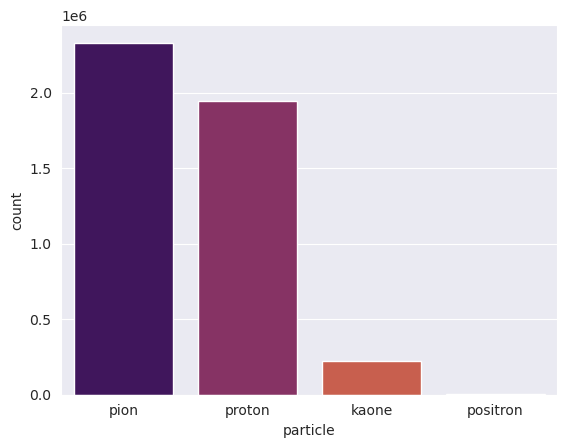

In [26]:
with sns.axes_style("darkgrid"):
    sns.countplot(x = df['particle'],
                palette='inferno')

print(df['particle'].value_counts(normalize = True) * 100)

As can be seen, the **positrons** and **kaons** are only about $5\%$ and $0.16\%$, respectively, i.e., they are *underrepresented* classes. Therefore, it is necessary to perform a **resampling** of the dataset in such a way that all classes are equirappresented and we do not have an unbalanced dataset.

In particular we are going to perform a **undersampling**, through the `RandomUnderSampler` object offered by the [`imbalanced Learn`] library (https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html).

In [27]:
# I show the number of particles for each class. 
sp = df['particle'].value_counts()
print(sp)

pion        2332465
proton      1945457
kaone        225613
positron       7304
Name: particle, dtype: int64


In [28]:
from imblearn.under_sampling import RandomUnderSampler

In [29]:
# Resampling - Undersampling
x = pd.DataFrame(df)
y = x['particle']

undersample = RandomUnderSampler(sampling_strategy='not minority')
df_us, _ = undersample.fit_resample(x, y)

kaone       7304
pion        7304
positron    7304
proton      7304
Name: particle, dtype: int64


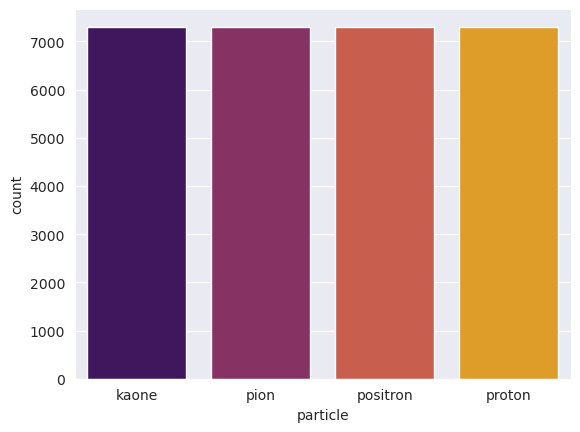

In [30]:
# I show the new number of particles for each class.
print(df_us['particle'].value_counts())

with sns.axes_style("darkgrid"):
    sns.countplot(x = df_us['particle'],
                palette='inferno')

In [31]:
print("Number of Particles in the Initial DataSet: {}\n".format(df.shape[0]))
print("Number of Particles in the Final DataSet: {}\n".format(df_us.shape[0]))
print("The DataSet was reduced by {:.2%}".format((df.shape[0]-df_us.shape[0])/df.shape[0]))

Number of Particles in the Initial DataSet: 4510839

Number of Particles in the Final DataSet: 29216

The DataSet was reduced by 99.35%


Now that the dataset is balanced, I see if there is any correlation between the features by means of a [correlation matrix](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).

C:\Users\Marco Cecca\AppData\Local\Temp;\ipykernel_15956\3759577882.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_us.corr(method="spearman"), annot = True, cmap="inferno")


<AxesSubplot: >

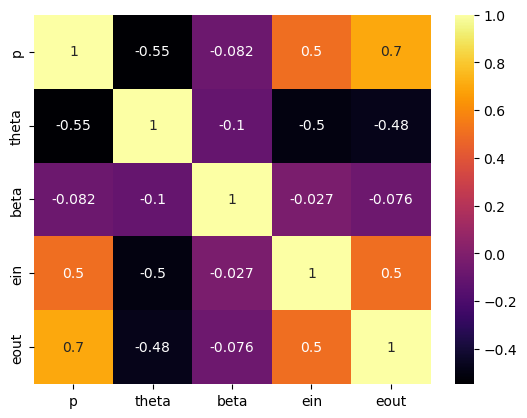

In [32]:
sns.heatmap(df_us.corr(method="spearman"), annot = True, cmap="inferno")

The only significant correlation I can detect is between *quantity of motion* and *outgoing energy*: physically this is consistent, since the fastest particles are also the most energetic.


Considering the **$\beta$** and **$p$** instead, I certainly do not have a linear correlation, but I observe in what relationship they are to each other, since I know theoretically that relativistic velocity is related to momentum as follows:

$$\beta=\sqrt{\frac{1}{1+\frac{m^2c^2}{p^2}}}\Longleftrightarrow y=\sqrt{\frac{1}{1+\frac{A}{x^2}}}$$

Where **$A$** is a parameter closely related to the mass of the particle.

Therefore from the figure below it is easy to see how particles can be distinguished by their **mass**.


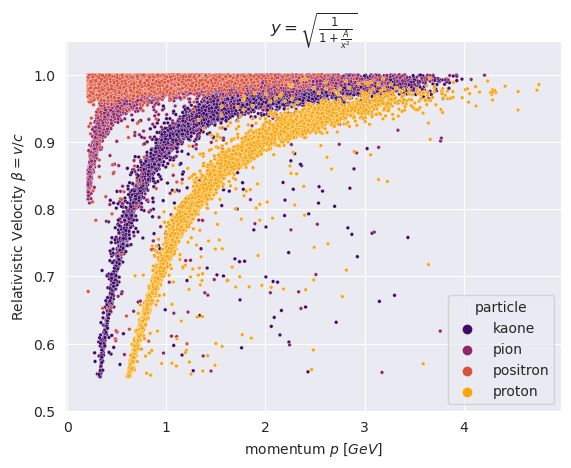

In [33]:
with sns.axes_style("darkgrid"):
    sns.scatterplot(
        data=df_us,
        x='p',
        y='beta',
        hue='particle',
        s = 7,
        palette = 'inferno'
        ).set(xlabel='momentum $p$ $[GeV]$',
              ylabel='Relativistic Velocity $\\beta=v/c$',
              title = "$y=\sqrt{\\frac{1}{1+\\frac{A}{x^2}}}$ ",
              ylim = (0.5,1.05))

Recalling the masses of the particles I have that:

$$m_{e^+} < m_{pi} < m_{K} < m_{p}$$

The behavior of the different particles can be distinguished according to their masses: in fact, the *positrons* which are the *lightest* leptons are close to the relativistic limit ($\beta\approx1$), while the *protons* which are the *heaviest* hadrons are present at the bottom of the plot.


I now create a function that makes me visually understand how the particles are distributed with respect to their features.

To do this I use an easy to interpret **kernel density estimation plot KDE**, `sns.kdeplot()`. Similarly I could also use `sns.displot(kind = "kde")`.


In [34]:
def distribution(colonna, target = 'particle'): #Plot a graph for each type of particle.
    for tag in df_us[target].unique(): 
        with sns.axes_style("darkgrid"):
            sns.kdeplot(data=df_us[df_us[target] == tag][colonna], label = tag, palette = 'inferno')
    with sns.axes_style("darkgrid"):
        sns.kdeplot(data=df_us[colonna],label = "Tutte", fill = True, palette = 'inferno')
    plt.legend()

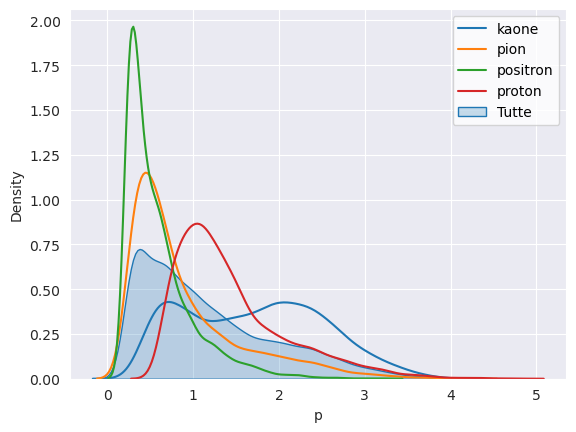

In [35]:
distribution('p')

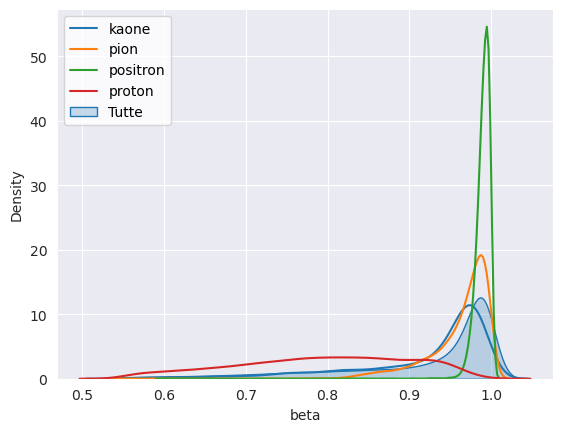

In [36]:
distribution('beta')

As expected, the various features are not normally distributed, but the algorithms we will make use of are not strongly influenced by the normalization of numerical data.

## **Model Building & Training**

Having done the data cleaning, we now turn to the *creation* and *training* of learning models. In particular, we will make use of supervised training models for classification such as the **Decision Tree**, **Random Forest**, **Multilayer Perceptron** and **K-Nearest Neighbor**. In addition, the efficiency of the models will be evaluated by means of a **confusion matrix** and **accuracy**.

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

I start by splitting the dataset for *training* and *test*, choosing the $80\%$ of the dataset for training.

The `random_state` attribute is for test reproducibility.

In [38]:
x = df_us.drop(columns = ['particle']) # Features of course are all those except the particle name
y = df_us['particle'] # label

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2022, train_size = 0.8)

### **Decision Tree**.

As a first model I use a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), leaving the default parameters. In general **decision trees** create a model that predicts a class or value in output from *binary* type rules inferred from the *features* of the data.

In [39]:
dt_class = DecisionTreeClassifier(random_state=2022)
dt_class.fit(x_train, y_train)
y_pred_dt = dt_class.predict(x_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

To evaluate its efficiency I use a `ConfusionMatrixDisplay`, showing what percentage each label was predicted and I also consider the `accuracy_score`:

Accuracy DecisionTree:
89.96%


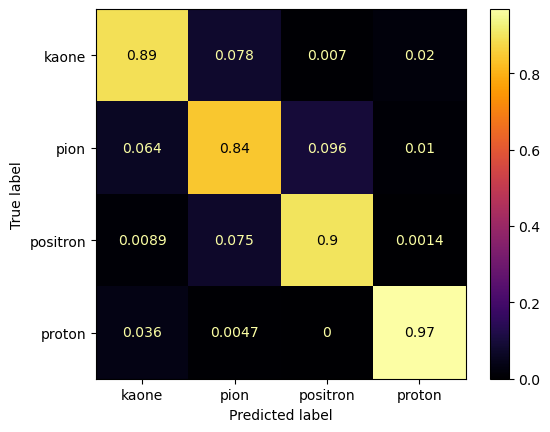

In [40]:
print('Accuracy DecisionTree:\n{:.2%}'.format(dt_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_dt,
                                        cmap='inferno',
                                        normalize = 'pred')

### **Random Forest**

As a second model I use a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), changing the parameters `n_estimators` and `n_jobs`.

The former varies the number of ``trees in the forest*`, the latter is purely to make use of the whole CPU.

In fact, a Random Forest is an **ensemble method** based on *decision trees*. That is, it combines several algorithms, generally achieving better results. Specifically, each *forest tree* is modeled on a subset of the data and features in the training set.

The results from each of the trees will then be *mediated and combined*, yielding a generally better result than the individual tree.

In [41]:
rf_class = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=2022)
rf_class.fit(x_train, y_train)
y_pred_rf = rf_class.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

Again, I use to evaluate its efficiency I use a `ConfusionMatrixDisplay` and the `accuracy_score`:

Accuracy RandomForest:
92.90%


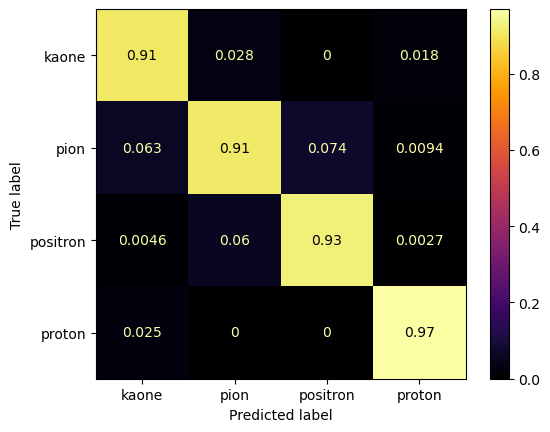

In [42]:
print('Accuracy RandomForest:\n{:.2%}'.format(rf_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_rf,
                                        cmap='inferno',
                                        normalize = 'pred')

In this case, however, I also evaluate the **importance of features** associated by the model for particle classification.

To do this, I use the `feature_importances_` attribute and display the results via a *barplot*.

In [43]:
importance = pd.DataFrame(data={'Feature': x_train.columns,
                                'Importance': rf_class.feature_importances_})
importance.head()

,Feature,Importanza
0,p,0.341387
1,theta,0.057864
2,beta,0.434335
3,ein,0.100989
4,eout,0.065424


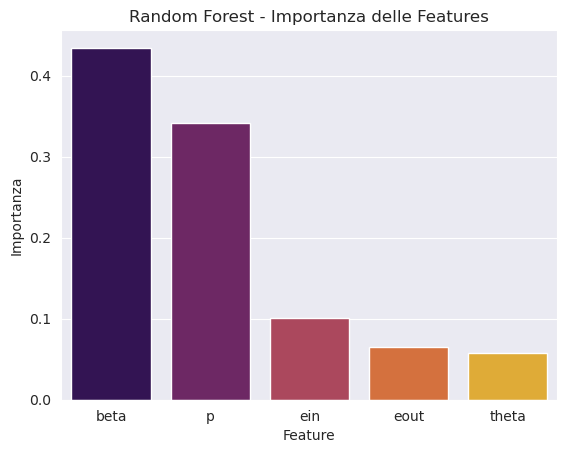

In [45]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = importance,
                x=importance['Feature'],
                y=importance['Importanza'], 
                order = importance.sort_values('Importanza',ascending = False).Feature, 
                palette = 'inferno').set(title = "Random Forest - Importance delle Features")

As can be seen, the most important features for model training and subsequent prediction are the *quantity of motion $p$* and the *relativistic velocity $\beta$*. This was predictable from the previous kinematic plot, through which it is possible to distinguish, and thus classify, the various particles.

### **Multilayer Perceptron**.

As a third model I use an [`MLPclassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). A **Multilayer Perceptron** is the simplest **neural network** model that is possible to devise. In practice, it is an algorithm that considers a relation of the type:

$$f:\mathbb{R}^5\to\mathbb{R}^4$$

The *imput layer* consists in our case of $5$ *neurons*, while the *output layer* consists of $4$, in between are the hidden *layers*. Each neuron in the hidden layer transforms the values of the previous layer with a weighted summation followed by an *activation function* (`logistic`, `tanh`, `relu`).

For the choice of parameters, in this case I use a **hyperparameter optimization** technique, via the [`GridSearchCV()`] object (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

The *grid search* tries to run the algorithm on the training data for each parameter combination within a given grid, until it finds the best possible one.

In [47]:
grid_parameter = [
    
        {
            'activation' : ['logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [(1,),(5,),(10,),(100,)]
        }
       ]

In [48]:
mlp_class = MLPClassifier(max_iter=300, random_state=2022)
mlp_upgrade = GridSearchCV(mlp_class, grid_parameter, n_jobs=-1)
mlp_upgrade.fit(x_train, y_train)

print("The best parameters for the MLPClassifier are:\n{}\n".format(mlp_upgrade.best_params_))

y_pred_mlp = mlp_upgrade.predict(x_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)


The best parameters for the MLPClassifier are:
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}



c:\Users\Marco Cecca\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Again I use to evaluate its efficiency I use a `ConfusionMatrixDisplay` and the `accuracy_score`:

Accuracy RandomForest:
93.46%


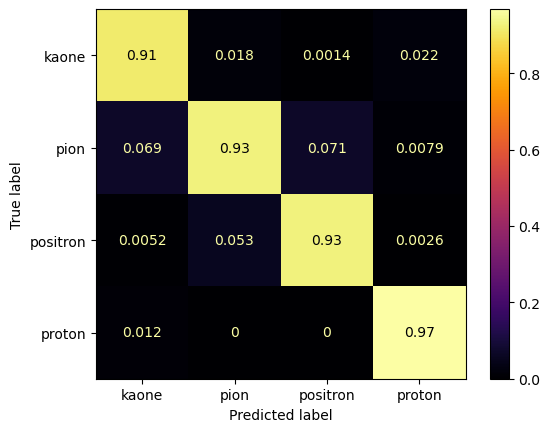

In [49]:
print('Accuracy RandomForest:\n{:.2%}'.format(mlp_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_mlp,
                                        cmap='inferno',
                                        normalize = 'pred')

### **K-Nearest Neighbor(KNN)**.

As a fourth and final model I consider the [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). The latter classifier is based on the *KN* algorithm that uses *proximity* to perform classifications on the grouping of a single data point. Simply put, this algorithm thinks that the closer things are to each other, the more similar they are.

The *distance* is evaluated between the point under consideration and the **K closest points** using several metrics, including the one we will use, which is the default one, the [`Minkowski distance`](https://it.wikipedia.org/wiki/Distanza_di_Minkowski).

In [50]:
knn_class = KNeighborsClassifier()
knn_class.fit(x_train, y_train)
y_pred_knn = knn_class.predict(x_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

I always use a `ConfusionMatrixDisplay` and the `accuracy_score`:

Accuracy K-Nearest Neighbor:
88.28%


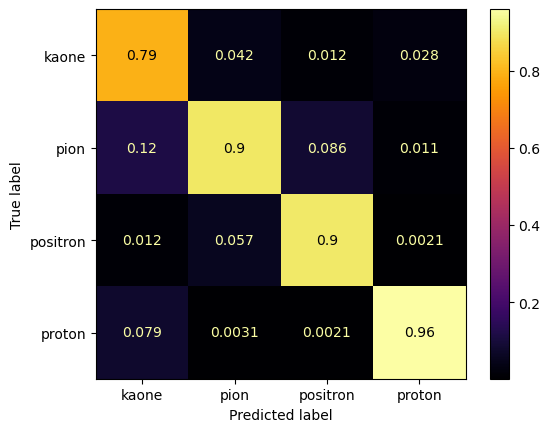

In [51]:
print('Accuracy K-Nearest Neighbor:\n{:.2%}'.format(knn_accuracy))
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred_knn,
                                        cmap='inferno',
                                        normalize = 'pred')

## **Comparison & Conclusion**

I conclude by comparing the classification models tested through their **accuracy**

In [52]:
accuracy_vector = np.array([dt_accuracy, rf_accuracy, mlp_accuracy, knn_accuracy])
classificatori = np.array(['Decision Tree', 'Random Forest', 'ML Perceptron', 'K-Nearest Neighbor'])

df_acc = pd.DataFrame({"Classifier": classificatori,
                   "Accuracy": accuracy_vector})

,Classifier,Accuracy
0,Decision Tree,0.899555
1,Random Forest,0.928987
2,ML Perceptron,0.934634
3,K-Nearest Neighbor,0.882786


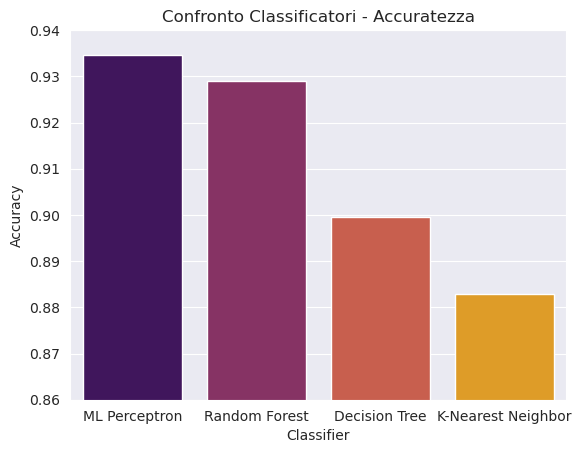

In [53]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = df_acc,
                x=df_acc['Classifier'],
                y=df_acc['Accuracy'], 
                order = df_acc.sort_values('Accuracy',ascending = False).Classifier, 
                palette = 'inferno').set(title = "Confronto Classificatori - Accuratezza",
                                        ylim=(0.86,0.94))
df_acc.head()

From which it can be concluded, considering the accuracy of the models, that they all perform very well, but the least efficient is the model based on the *K-Nearest Neighbor* algorithm.